# Stock Market Analysis

## Business Problem

 - A stock market investor is looking to invest in a portfolio consisting of three technology companies, three healthcare companies, as well as one cryptocurrency for the next six month period. This notebook will analyze the top ten tech and healthcare stocks according to volumne traded as well the top five cryptocurrency stocks by volume traded. The stocks will then be analyzed according to past future returns dating back to January 2016 as well as the stocks' volitility and P/E ratios over that period. A sarima model, RNN, and Facebook Prophet model will then be run on each of the stocks in order to predict future returns over the next six month period. Model results will then be compared and analyzed, and portfolio investment reccomendations will then be provided. 

## Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import pandas_datareader
import pandas_datareader.data as web
import datetime
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tools.eval_measures import rmse
from pmdarima import auto_arima
from sklearn.preprocessing import MinMaxScaler
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.preprocessing.sequence import TimeseriesGenerator
import yfinance as yf
from yahoo_fin.stock_info import get_data
import yahoo_fin.stock_info as si
import warnings
warnings.filterwarnings('ignore')

## Functions

In [2]:
def adfuller_of(series):
    """Prints the Augmented Dickey-Fuller test results."""
    
    adf, pvalue, usedlag, nobs, crit_vals, resstore = adfuller(series)
    print(f'''
                          ADF: {adf}
                      P-Value: {pvalue}
                     Used Lag: {usedlag}
       Number of Observations: {nobs}
    Critical Values (for ADF): {crit_vals}
                  ResultStore: {resstore}
    ''')

In [3]:
def get_data(stock):
    start = datetime.datetime(2016,1,1)
    end = datetime.datetime(2021,6,1)
    stock_df = web.DataReader(stock, 'yahoo', start, end)
    stock_df['Stock'] = stock
    stock_df['Returns'] = stock_df['Close'].pct_change(1)
    stock_df['Cumulative Return'] = (1 + stock_df['Returns']).cumprod()
    return stock_df

## Load Data/Data Description

### Top 10 Tech Stocks

In [4]:
apple = get_data('AAPL')

In [5]:
apple.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1362 entries, 2016-01-04 to 2021-06-01
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   High               1362 non-null   float64
 1   Low                1362 non-null   float64
 2   Open               1362 non-null   float64
 3   Close              1362 non-null   float64
 4   Volume             1362 non-null   float64
 5   Adj Close          1362 non-null   float64
 6   Stock              1362 non-null   object 
 7   Returns            1361 non-null   float64
 8   Cumulative Return  1361 non-null   float64
dtypes: float64(8), object(1)
memory usage: 106.4+ KB


In [6]:
apple.head()

,High,Low,Open,Close,Volume,Adj Close,Stock,Returns,Cumulative Return
Date,,,,,,,,,
2016-01-04,26.342501,25.500000,25.652500,26.337500,270597600.0,24.323219,AAPL,NaN,NaN
2016-01-05,26.462500,25.602501,26.437500,25.677500,223164000.0,23.713696,AAPL,-0.025059,0.974941
2016-01-06,25.592501,24.967501,25.139999,25.174999,273829600.0,23.249626,AAPL,-0.019570,0.955861
2016-01-07,25.032499,24.107500,24.670000,24.112499,324377600.0,22.268383,AAPL,-0.042205,0.915520
2016-01-08,24.777500,24.190001,24.637501,24.240000,283192000.0,22.386133,AAPL,0.005288,0.920361


In [7]:
microsoft = get_data('MSFT')

In [8]:
google = get_data('GOOG')

In [9]:
amazon = get_data('AMZN')

In [10]:
facebook = get_data('FB')

In [11]:
tencent = get_data('TCEHY')

In [12]:
alibaba = get_data('BABA')

In [13]:
tesla = get_data('TSLA')

In [14]:
tsmc = get_data('TSM')

In [15]:
nvidia = get_data('NVDA')

In [16]:
to_concat = [apple, microsoft, google, amazon, facebook, tencent, alibaba, tesla, tsmc, nvidia]
tech_df = pd.concat(to_concat)

In [17]:
tech_df.shape

(13620, 9)

In [18]:
tech_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13620 entries, 2016-01-04 to 2021-06-01
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   High               13620 non-null  float64
 1   Low                13620 non-null  float64
 2   Open               13620 non-null  float64
 3   Close              13620 non-null  float64
 4   Volume             13620 non-null  float64
 5   Adj Close          13620 non-null  float64
 6   Stock              13620 non-null  object 
 7   Returns            13610 non-null  float64
 8   Cumulative Return  13610 non-null  float64
dtypes: float64(8), object(1)
memory usage: 1.0+ MB


In [19]:
aapl_df = tech_df[tech_df['Stock'] == 'AAPL']
aapl_df.shape

(1362, 9)

In [20]:
msft_df = tech_df[tech_df['Stock'] == 'MSFT']
msft_df.shape

(1362, 9)

### Top 10 Healthcare Stocks

In [21]:
united_health = get_data('UNH')

In [22]:
cvs = get_data('CVS')

In [23]:
hca = get_data('HCA')

In [24]:
mckesson = get_data('MCK')

In [25]:
amerisource_bergen = get_data('ABC')

In [26]:
cerner = get_data('CERN')

In [27]:
teladoc_health = get_data('TDOC')

In [28]:
bio_rad = get_data('BIO')

In [29]:
cardinal_health = get_data('CAH')

In [30]:
perkin_elmer = get_data('PKI')

In [31]:
to_concat = [united_health, cvs, hca, mckesson, amerisource_bergen, cerner, teladoc_health,
            bio_rad, cardinal_health, perkin_elmer]
healthcare_df = pd.concat(to_concat)

In [32]:
healthcare_df.shape

(13620, 9)

In [33]:
healthcare_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13620 entries, 2016-01-04 to 2021-06-01
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   High               13620 non-null  float64
 1   Low                13620 non-null  float64
 2   Open               13620 non-null  float64
 3   Close              13620 non-null  float64
 4   Volume             13620 non-null  float64
 5   Adj Close          13620 non-null  float64
 6   Stock              13620 non-null  object 
 7   Returns            13610 non-null  float64
 8   Cumulative Return  13610 non-null  float64
dtypes: float64(8), object(1)
memory usage: 1.0+ MB


### Top 5 Cryptocurrency Stocks

In [34]:
bitcoin = get_data('BTC-USD')

In [35]:
ethereum = get_data('ETH-USD')

In [36]:
dogecoin = get_data('DOGE-USD')

In [37]:
xrp = get_data('XRP-USD')

In [38]:
litecoin = get_data('LTC-USD')

In [39]:
to_concat = [bitcoin, ethereum, dogecoin, xrp, litecoin]
crypto_df = pd.concat(to_concat)

In [40]:
crypto_df.shape

(9880, 9)

In [41]:
crypto_monthly = bitcoin.resample(rule='M').mean()

In [42]:
crypto_monthly.shape

(66, 8)

In [43]:
crypto_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9880 entries, 2016-01-01 to 2021-06-01
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   High               9880 non-null   float64
 1   Low                9880 non-null   float64
 2   Open               9880 non-null   float64
 3   Close              9880 non-null   float64
 4   Volume             9880 non-null   float64
 5   Adj Close          9880 non-null   float64
 6   Stock              9880 non-null   object 
 7   Returns            9875 non-null   float64
 8   Cumulative Return  9875 non-null   float64
dtypes: float64(8), object(1)
memory usage: 771.9+ KB


## Data Exploration

### Autocorrelation

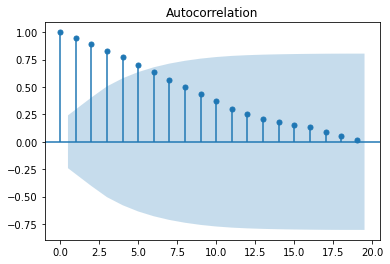

In [44]:
apple_monthly = apple.resample(rule='M').mean()
plot_acf(apple_monthly['Cumulative Return']);

### Decomposition

In [45]:
decomposition = seasonal_decompose(apple['Cumulative Return'].dropna(), period=365)

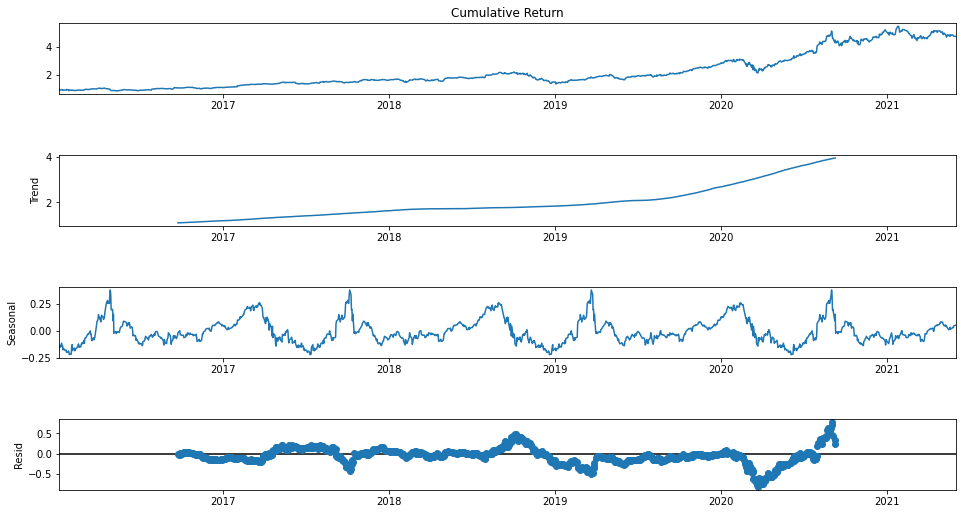

In [46]:
fig = decomposition.plot()
fig.set_size_inches(15,8)

### Dickey Fuller Test

### Rolling Mean Analysis

### Volitility Analysis

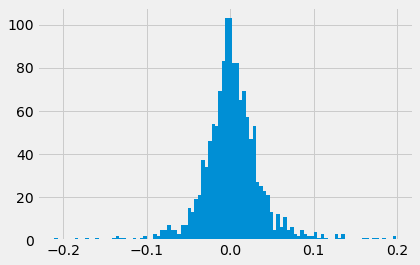

In [47]:
plt.style.use('fivethirtyeight')
tesla['Returns'].hist(bins=100);

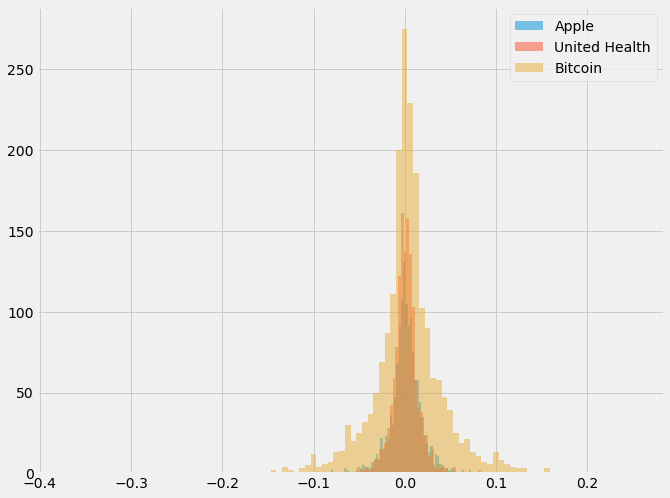

In [48]:
apple['Returns'].hist(bins=100, label='Apple', figsize=(10,8), alpha=0.5)
united_health['Returns'].hist(bins=100, label='United Health', figsize=(10,8), alpha=0.5)
bitcoin['Returns'].hist(bins=100, label='Bitcoin', figsize=(10,8), alpha=0.5)
plt.legend();

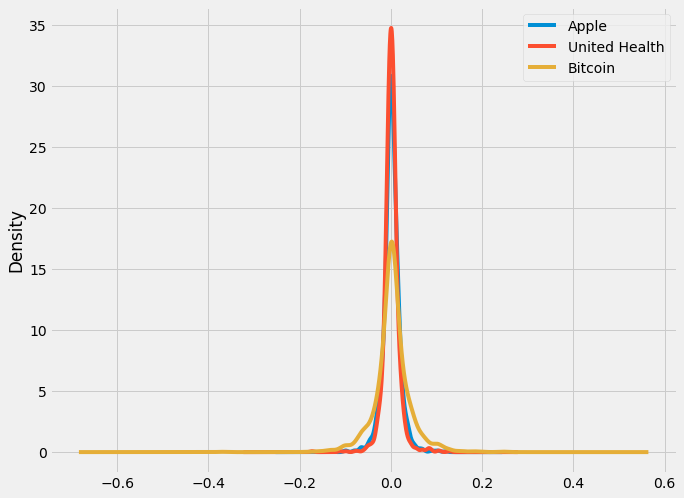

In [49]:
apple['Returns'].plot(kind='kde', label='Apple', figsize=(10,8))
united_health['Returns'].plot(kind='kde', label='United Health', figsize=(10,8))
bitcoin['Returns'].plot(kind='kde', label='Bitcoin', figsize=(10,8))
plt.legend();

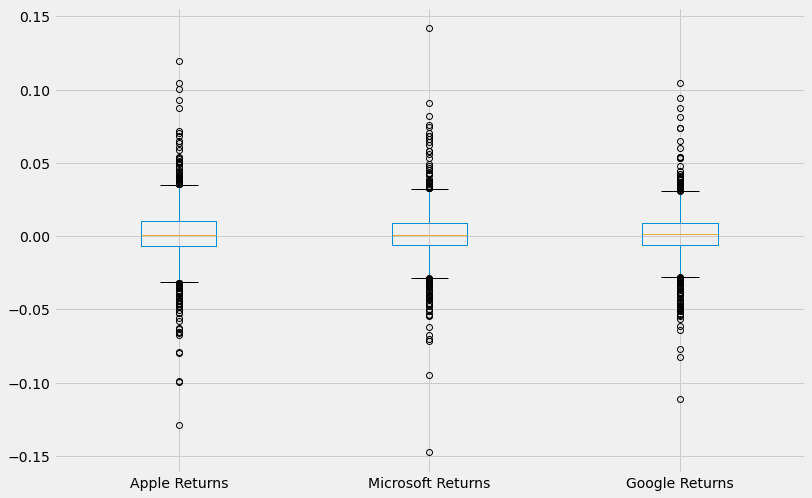

In [50]:
box_df = pd.concat([apple['Returns'], microsoft['Returns'], google['Returns']], axis=1)
box_df.columns = ['Apple Returns', 'Microsoft Returns', 'Google Returns']
box_df.plot(kind='box', figsize=(12,8));

In [51]:
def box_plot(stock1, stock2, stock3, title1, title2, title3):
    box_df = pd.concat([stock1['Returns'], stock2['Returns'], stock3['Returns']], axis=1)
    box_df.columns = [title1, title2, title3]
    box_df.plot(kind='box', figsize=(12,8));

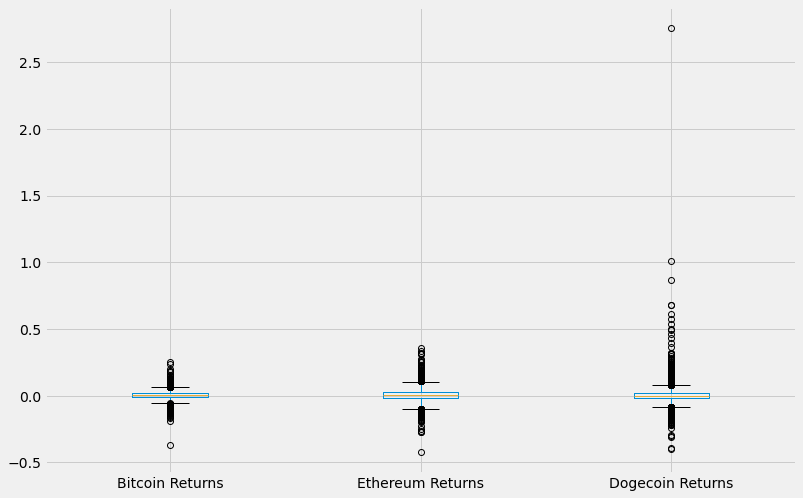

In [52]:
box_plot(bitcoin, ethereum, dogecoin, 'Bitcoin Returns', 'Ethereum Returns', 'Dogecoin Returns')

### Cumulative Returns Analysis

In [53]:
def returns_dict(df):
    """Takes in a"""
    returns_lst = []
    for s in df.Stock.unique():
        stock_df = df[(df['Stock'] == s)]
        ret = stock_df.iloc[-1,8]
        returns_lst.append(round(ret,2)) 
        
    stock_names = []
    for n in df.Stock.unique():
        stock_names.append(n)
    
    returns_dict = dict(zip(stock_names, returns_lst))
    return(returns_dict)

In [54]:
tech_returns = returns_dict(tech_df)

In [55]:
crypto_returns = returns_dict(crypto_df)

In [56]:
health_returns = returns_dict(healthcare_df)

In [57]:
def returns_df(returns_dict):
    returns_df = pd.DataFrame(list(returns_dict.items()),columns = ['Stock','Cumulative Return']) 
    sorted_df = returns_df.sort_values(by='Cumulative Return', ascending=False).reset_index(drop=True)
    return sorted_df

In [58]:
tech_returns_df = returns_df(tech_returns)
tech_returns_df

,Stock,Cumulative Return
0,NVDA,20.10
1,TSLA,13.96
2,TSM,5.36
3,AMZN,5.05
4,AAPL,4.72
5,MSFT,4.51
6,TCEHY,4.25
7,GOOG,3.28
8,FB,3.22
9,BABA,2.86


In [59]:
health_returns_df = returns_df(health_returns)
health_returns_df

,Stock,Cumulative Return
0,TDOC,8.47
1,BIO,4.27
2,UNH,3.49
3,HCA,3.26
4,PKI,2.70
5,CERN,1.34
6,ABC,1.12
7,MCK,0.99
8,CVS,0.89
9,CAH,0.63


In [60]:
crypto_returns_df = returns_df(crypto_returns)
crypto_returns_df 

,Stock,Cumulative Return
0,ETH-USD,2854.49
1,DOGE-USD,2749.18
2,XRP-USD,172.02
3,BTC-USD,86.51
4,LTC-USD,53.37


In [61]:
def plot_returns(df, title, graph_color):
    ax = df.sort_values('Cumulative Return').plot.barh(x='Stock', figsize=(12,8), color=graph_color)
    plt.title(title)
    plt.xlabel('Cumulative Return %')

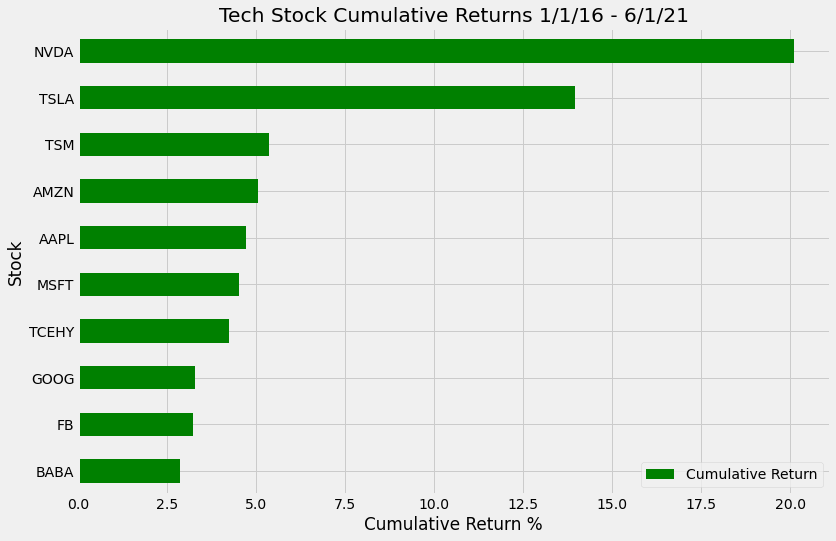

In [62]:
plot_returns(tech_returns_df, 'Tech Stock Cumulative Returns 1/1/16 - 6/1/21', 'g')

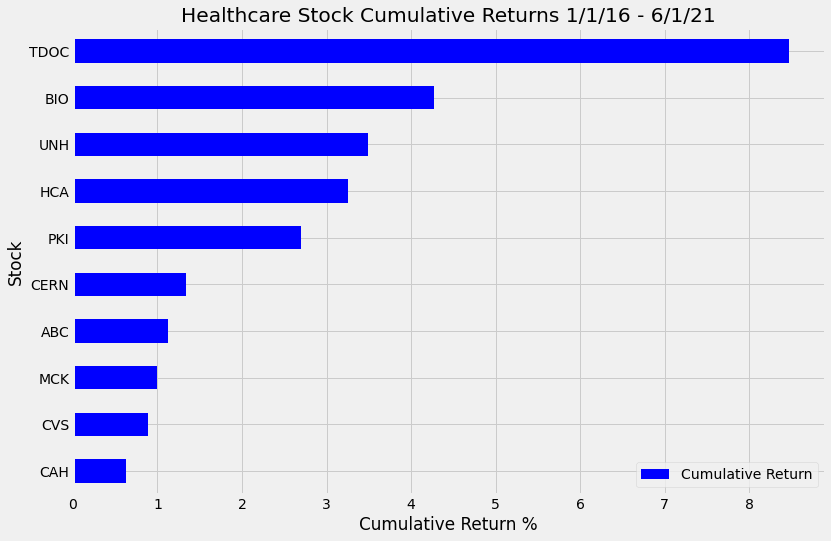

In [63]:
plot_returns(health_returns_df, 'Healthcare Stock Cumulative Returns 1/1/16 - 6/1/21', 'b')

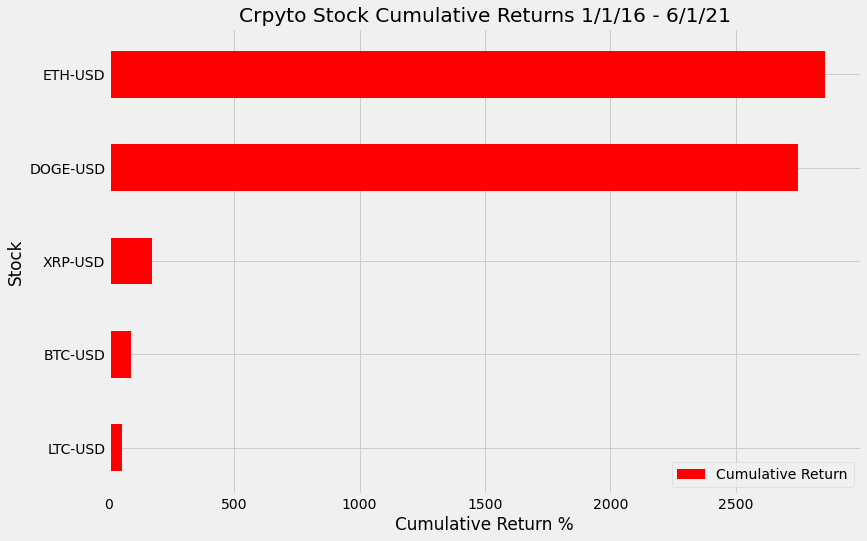

In [64]:
plot_returns(crypto_returns_df, 'Crpyto Stock Cumulative Returns 1/1/16 - 6/1/21', 'r')

### P/E Ratio Analysis

In [65]:
quote_table = si.get_quote_table('AAPL', dict_result=False)
quote_table.iloc[13]

attribute    PE Ratio (TTM)
value                 29.33
Name: 13, dtype: object

## Modeling

### SARIMA Models

In [66]:
def sarima_model_fcast(df, graph_title, graph_color):
    """Takes in a dataframe, runs a stepwise fit and SARIMA model on each stock and returns a dictionary of."""
    forecasted_returns = []
    for s in df.Stock.unique():
        stock_df = df[(df['Stock'] == s)]
        monthly_df = stock_df.resample(rule='M').mean()
        train = monthly_df['Cumulative Return'].iloc[:54]
        stepwise_fit = auto_arima(train)
        model_order = stepwise_fit.order
        future_model = SARIMAX(monthly_df['Cumulative Return'], order=model_order, seasonal_order=(1,1,0,7))
        results_future = future_model.fit()
        fcast = results_future.predict(len(monthly_df), len(monthly_df)+6, typ='levels').rename('SARIMA Forecast')
        fcast_df = pd.DataFrame(fcast)
        ret = fcast_df.iloc[-1,-1]
        forecasted_returns.append(round(ret,2))
        
    stock_names = []
    for n in df.Stock.unique():
        stock_names.append(n)
            
    returns_dict = dict(zip(stock_names, forecasted_returns))
    fcast_df = pd.DataFrame(list(returns_dict.items()),columns = ['Stock','Fcast Cumulative Return']) 
    ax = fcast_df.sort_values('Fcast Cumulative Return').plot.barh(x='Stock', figsize=(12,8), color=graph_color)
    plt.title(graph_title)
    plt.xlabel('Cumulative Return %')

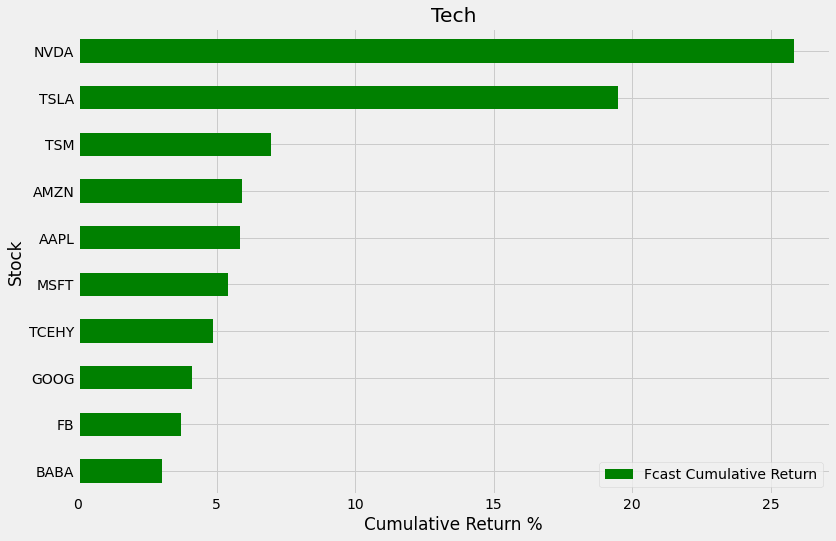

In [67]:
sarima_model_fcast(tech_df, 'Tech', 'g')

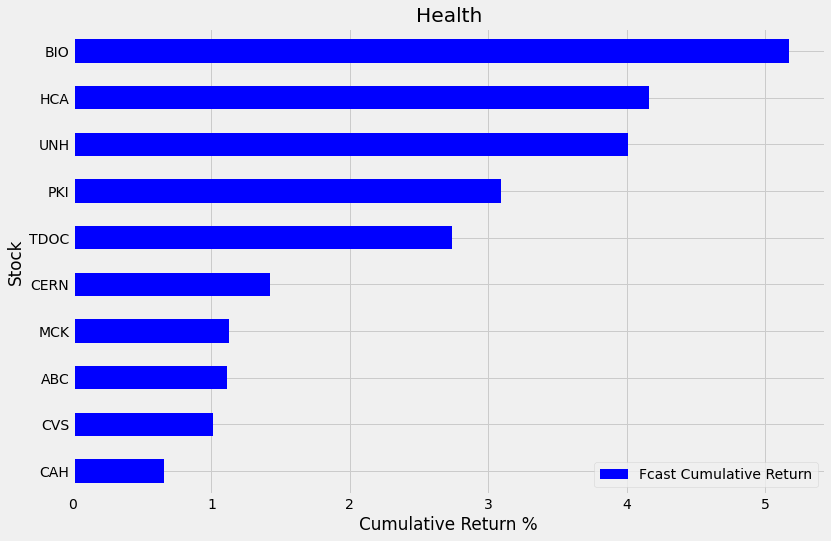

In [68]:
sarima_model_fcast(healthcare_df, 'Health', 'b')

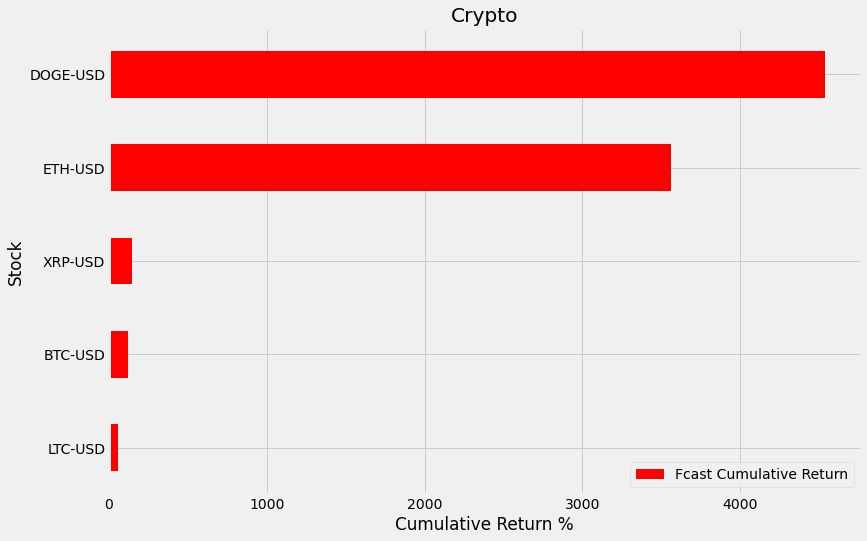

In [69]:
sarima_model_fcast(crypto_df, 'Crypto', 'r')

### SARIMA Model B

In [70]:
def plot_train_pred(stock_df, graph_title):

    monthly_df = stock_df.resample(rule='M').mean()

    train = monthly_df.iloc[:54]['Cumulative Return']
    test = monthly_df.iloc[54:]['Cumulative Return']

    stepwise_fit = auto_arima(train)
    model_order = stepwise_fit.order

    model = SARIMAX(train, order=model_order, seasonal_order=(1,1,0,7))
    results = model.fit()

    train_start = train.index.min()
    train_end = train.index.max()

    predictions = results.predict(start=train_start, end=train_end, typ='levels').rename('SARIMA Predictions')

    train.plot(legend=True, figsize=(12,8))
    predictions.plot(legend=True)
    plt.title(graph_title)

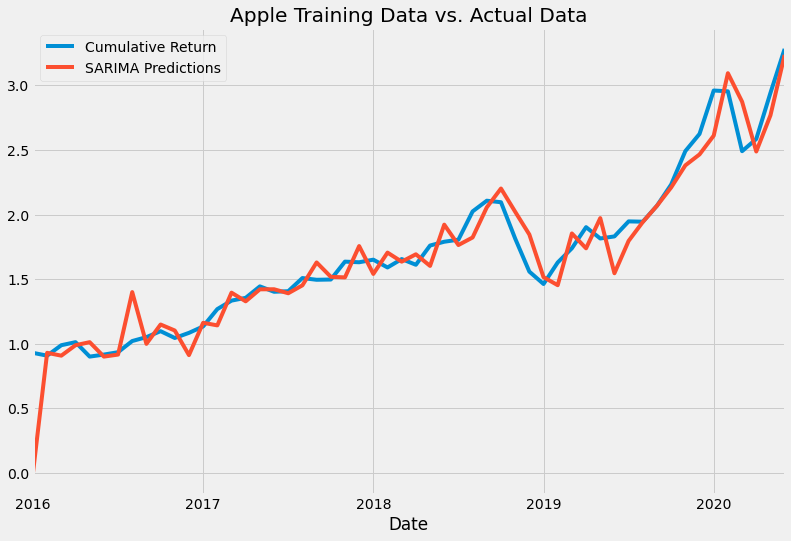

In [71]:
plot_train_pred(apple, 'Apple Training Data vs. Actual Data')

In [74]:
def plot_test_pred(stock_df, graph_title):

    monthly_df = stock_df.resample(rule='M').mean()

    train = monthly_df.iloc[:54]['Cumulative Return']
    test = monthly_df.iloc[54:]['Cumulative Return']

    stepwise_fit = auto_arima(train)
    model_order = stepwise_fit.order

    model = SARIMAX(train, order=model_order, seasonal_order=(1,1,0,7))
    results = model.fit()

    test_start = test.index.min()
    test_end = test.index.max()

    test_predictions = results.predict(start=test_start, end=test_end, typ='levels').rename('SARIMA Predictions')

    test.plot(legend=True, figsize=(12,8))
    test_predictions.plot(legend=True)
    plt.title(graph_title)

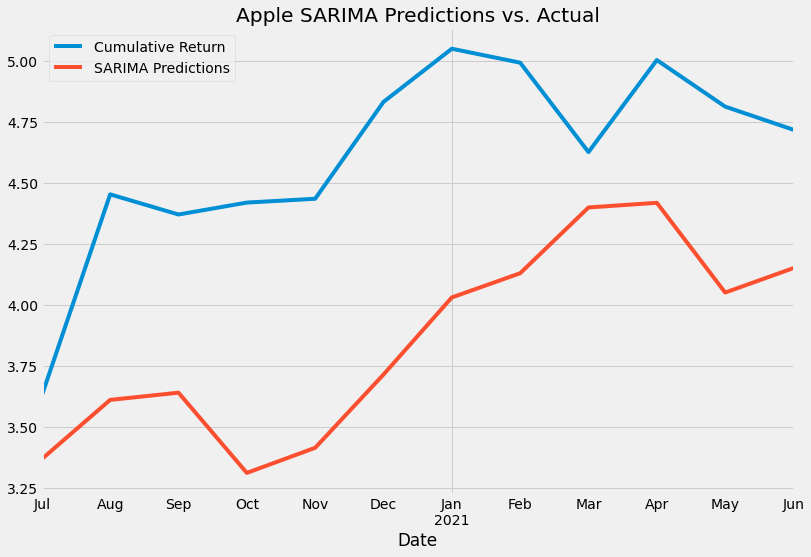

In [75]:
plot_test_pred(apple, 'Apple SARIMA Predictions vs. Actual')

In [78]:
#RMSE
def model_rmse(stock_df):

    resampled = stock_df.resample(rule='M').mean()

    train = resampled.iloc[:54]['Cumulative Return']
    test = resampled.iloc[54:]['Cumulative Return']

    stepwise_fit = auto_arima(train)
    model_order = stepwise_fit.order

    model = SARIMAX(train, order=model_order, seasonal_order=(1,1,0,7))
    results = model.fit()

    test_start = test.index.min()
    test_end = test.index.max()

    test_predictions = results.predict(start=test_start, end=test_end, typ='levels').rename('SARIMA Predictions')
    error = rmse(test, test_predictions)
    mean = test.mean()
    return round(error,2), round(mean,2)

In [79]:
model_rmse(apple)

(0.81, 4.61)

In [80]:
def plot_fcast(stock_df, graph_title):
    monthly_df = stock_df.resample(rule='M').mean()
    train = monthly_df.iloc[:54]['Cumulative Return']
    stepwise_fit = auto_arima(train)
    model_order = stepwise_fit.order
    future_model = SARIMAX(monthly_df['Cumulative Return'], order=model_order, seasonal_order=(1,1,0,7))
    results_future = future_model.fit()
    fcast = results_future_b.predict(len(monthly_df), len(monthly_df)+6, typ='levels').rename('SARIMA Forecast')
    monthly_df['Cumulative Return'].plot(legend=True, figsize=(12,8))
    fcast.plot(legend=True)
    plt.title(graph_title);

In [83]:
def plot_fcast_2(stock_df, graph_title):
    monthly_df = stock_df.resample(rule='M').mean()
    train = monthly_df.iloc[:54]['Cumulative Return']
    stepwise_fit = auto_arima(train)
    model_order = stepwise_fit.order
    future_model = SARIMAX(monthly_df['Cumulative Return'], order=model_order, seasonal_order=(1,1,0,7))
    results_future = future_model.fit()
    fcast = results_future.predict(len(monthly_df), len(monthly_df)+6, typ='levels').rename('SARIMA Forecast')
    conf_int = results_future.get_forecast(6)
    fcast_ci = conf_int.conf_int(alpha=0.05).rename(columns={'lower value':'Lower 95% Confidence Interval','upper value':'Upper 95% Confidence Interval'})
    fcast_ci.plot(linestyle='dotted')
    monthly_df['Cumulative Return'].plot(legend=True, figsize=(12,8))
    fcast.plot(legend=True)
    plt.title(graph_title);
    

    
    
    #return ,monthly_df['value'].plot(legend=True, label='Actual Mean Home Value', figsize=(12,8)), fcast.plot(legend=True), plt.grid(), plt.title(title), plt.xlabel('Year'), plt.ylabel('Value US$')

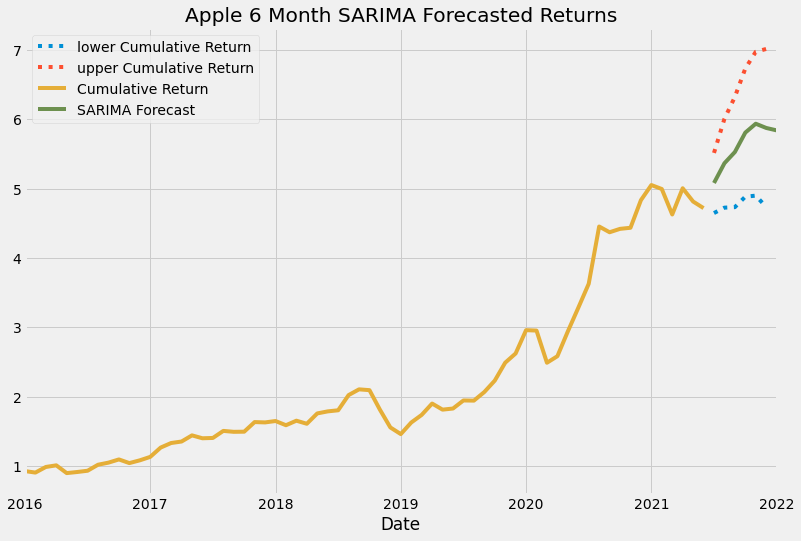

In [84]:
plot_fcast_2(apple, 'Apple 6 Month SARIMA Forecasted Returns')

### RNN Models

In [ ]:
resampled = apple.resample(rule='M').mean()

In [ ]:
resampled.shape

In [ ]:
train = resampled.iloc[:54]
test = resampled.iloc[54:]

In [ ]:
train.shape

In [ ]:
test.shape

In [ ]:
scaler = MinMaxScaler()

In [ ]:
scaler.fit(train[['Cumulative Return']])

In [ ]:
scaled_train = scaler.transform(train[['Cumulative Return']])
scaled_test = scaler.transform(test[['Cumulative Return']])

In [ ]:
len(scaled_train)

In [ ]:
scaled_train[:5]

In [ ]:
X,y = generator[0]

In [ ]:
X

In [ ]:
y

In [ ]:
n_input = 12
n_features = 1

train_generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [ ]:
model = Sequential()

model.add(LSTM(150, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(LSTM(64, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
model.summary()

In [ ]:
model.fit_generator(train_generator, epochs=20)

In [ ]:
plt.plot(range(len(model.history.history['loss'])), model.history.history['loss'])

In [ ]:
first_eval_batch = scaled_train[-12:]

In [ ]:
first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))

In [ ]:
model.predict(first_eval_batch)

### RNN Forecast

In [ ]:
test_predictions = []
first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    current_pred = model.predict(current_batch)[0]
    
    test_predictions.append(current_pred)
    
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)

In [ ]:
test_predictions

In [ ]:
true_predictions = scaler.inverse_transform(test_predictions)

In [ ]:
true_predictions

In [ ]:
test['Predictions'] = true_predictions

In [ ]:
test['Cumulative Return'].plot(legend=True)
test['Predictions'].plot(legend=True)

### Facebook Prophet Model

In [ ]:
from fbprophet import Prophet

In [ ]:
def fb_prophet_model(df, graph_title, graph_color):
    forecasted_returns = []
    for s in df.Stock.unique():
        stock_df = df[(df['Stock'] == s)]
        returns_df = pd.DataFrame(stock_df['Cumulative Return'])
        monthly_df = returns_df.resample(rule='M').mean()
        monthly_df.reset_index(inplace=True)
        monthly_df.columns = ['ds', 'y']
        monthly_df['ds'] = pd.to_datetime(monthly_df['ds'])
        train = monthly_df[:54]
        test = monthly_df[54:]
        m = Prophet()
        m.fit(train)
        future = m.make_future_dataframe(periods=18, freq='M')
        forecast = m.predict(future)
        ret = forecast.iloc[-1,-1]
        forecasted_returns.append(round(ret,2))
        
    stock_names = []
    for n in df.Stock.unique():
        stock_names.append(n)
            
    returns_dict = dict(zip(stock_names, forecasted_returns))
    fcast_df = pd.DataFrame(list(returns_dict.items()),columns = ['Stock','Fcast Cumulative Return']) 
    ax = fcast_df.sort_values('Fcast Cumulative Return').plot.barh(x='Stock', figsize=(12,8), color=graph_color)
    plt.title(graph_title)
    plt.xlabel('Cumulative Return %')

In [ ]:
fb_prophet_model(tech_df, 'Tech', 'g')

In [ ]:
apple_returns = pd.DataFrame(apple['Cumulative Return'])
apple_returns_m = apple_returns.resample(rule='M').mean()
apple_returns_m.reset_index(inplace=True)

In [ ]:
apple_returns_m.columns = ['ds', 'y']
apple_returns_m.head()

In [ ]:
apple_returns_m['ds'] = pd.to_datetime(apple_returns_m['ds'])

In [ ]:
apple_returns_m.info()

In [ ]:
apple_returns_m.shape

In [ ]:
train_c = apple_returns_m[:54]
test_c = apple_returns_m[54:]

In [ ]:
test_c.shape

In [ ]:
#apple_returns_m[:54]

In [ ]:
m = Prophet()
m.fit(train_c)
future = m.make_future_dataframe(periods=18, freq='M')
forecast = m.predict(future)

In [ ]:
forecast.shape

In [ ]:
m.plot(forecast);

In [ ]:
len(apple_returns_m)

In [ ]:
test_c

In [ ]:
forecast.iloc[-1,-1]

In [ ]:
ax = forecast.plot(x='ds', y ='yhat', label='Predictions', legend=True, figsize=(12,8))
test_c.plot(x='ds', y='y', label='True Test Data', legend=True, ax=ax, xlim=('2020-07-31', '2021-12-01'))

In [ ]:
predictions = forecast.iloc[-12:]['yhat']

In [ ]:
predictions

In [ ]:
test_c['y']

In [ ]:
rmse(predictions, test_c['y'])

In [ ]:
test_c.mean()

## Models Comparison

## Portfolio Recommendations

## Live Dash

## Conclusion